In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Objetivo

Você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

- Apresentar modelo com storytelling;

- Justificar a técnica utilizada;

- Atingir acurácia mínimia de 70%.

**Dados**: https://br.investing.com/indices/bovespa-historical-data

# Leitura e processamento dos dados

In [40]:
dados_path = './data/dados_ibovespa_2010-2023.csv'

dados = pd.read_csv(dados_path)

dados

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,24.08.2023,117.026,118.135,118.136,116.848,"9,20M","-0,94%"
1,23.08.2023,118.135,116.160,118.135,116.159,"11,54M","1,70%"
2,22.08.2023,116.156,114.433,116.286,114.433,"9,83M","1,51%"
3,21.08.2023,114.429,115.404,115.425,114.067,"9,79M","-0,85%"
4,18.08.2023,115.409,114.973,115.729,114.423,"10,60M","0,37%"
...,...,...,...,...,...,...,...
3376,08.01.2010,70.263,70.455,70.766,70.158,"1,63M","-0,27%"
3377,07.01.2010,70.451,70.723,70.723,70.045,"1,55M","-0,39%"
3378,06.01.2010,70.729,70.237,70.937,70.016,"2,24M","0,70%"
3379,05.01.2010,70.240,70.046,70.595,69.928,"1,98M","0,28%"


In [41]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3381 non-null   object 
 1   Último    3381 non-null   float64
 2   Abertura  3381 non-null   float64
 3   Máxima    3381 non-null   float64
 4   Mínima    3381 non-null   float64
 5   Vol.      3380 non-null   object 
 6   Var%      3381 non-null   object 
dtypes: float64(4), object(3)
memory usage: 185.0+ KB
None


In [42]:
print(dados.isna().sum())

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64


Existem algumas inconsistências na base. Coluna de data está como tipo texto, variáveis numéricas em formato texto e existe um valor nulo na coluna "Vol."

## Ajuste nos tipos de dados

In [43]:
# Coluna Data com tipo datetime
dados = pd.read_csv(dados_path, parse_dates=[0])

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2023-08-24,117.026,118.135,118.136,116.848,"9,20M","-0,94%"
1,2023-08-23,118.135,116.160,118.135,116.159,"11,54M","1,70%"
2,2023-08-22,116.156,114.433,116.286,114.433,"9,83M","1,51%"
3,2023-08-21,114.429,115.404,115.425,114.067,"9,79M","-0,85%"
4,2023-08-18,115.409,114.973,115.729,114.423,"10,60M","0,37%"


In [44]:
dados['Vol.'] = dados['Vol.'].str[:-1]
dados['Var%'] = dados['Var%'].str[:-1]

dados['Vol.'] = dados['Vol.'].str.replace(',','.')
dados['Var%'] = dados['Var%'].str.replace(',','.')

dados['Vol.'] = dados['Vol.'].astype(float)
dados['Var%'] = dados['Var%'].astype(float)

In [45]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      3381 non-null   datetime64[ns]
 1   Último    3381 non-null   float64       
 2   Abertura  3381 non-null   float64       
 3   Máxima    3381 non-null   float64       
 4   Mínima    3381 non-null   float64       
 5   Vol.      3380 non-null   float64       
 6   Var%      3381 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 185.0 KB
None


## Valores nulos

In [46]:
dados.loc[dados['Vol.'].isna()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1872,2016-10-02,40.377,40.592,40.592,39.96,NaN,-0.53


Por se tratar de apenas uma linha no dataframe, será adotada a técnica de exclusão da linha com valores nulos, pois não prejudicará a representação dos dados.

In [47]:
dados.dropna(inplace=True)

dados.loc[dados['Vol.'].isna()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%


## Renomeando colunas

Para facilitar as análises futuras e simplificar a nomenclatura das variáveis, os nomes das colunas também serão modificados

In [48]:
print(dados.columns)

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')


In [49]:
dados.columns = ['ds', 'y', 'abertura', 'max', 'min', 'volume', 'variacao']

dados.head()

,ds,y,abertura,max,min,volume,variacao
0,2023-08-24,117.026,118.135,118.136,116.848,9.20,-0.94
1,2023-08-23,118.135,116.160,118.135,116.159,11.54,1.70
2,2023-08-22,116.156,114.433,116.286,114.433,9.83,1.51
3,2023-08-21,114.429,115.404,115.425,114.067,9.79,-0.85
4,2023-08-18,115.409,114.973,115.729,114.423,10.60,0.37


## Exportação da base processada

In [50]:
dados.to_csv('./data/dados_ibovespa_2010-2023_processed.csv', index=False)

# Exploratory Data Analysis

## Variação

In [51]:
print(f'Variação máxima (%): {dados.variacao.max()}')
print(dados.loc[dados.variacao == dados.variacao.max()]['ds'])

print('\n')

print(f'Variação mínima (%): {dados.variacao.min()}')
print(dados.loc[dados.variacao == dados.variacao.min()]['ds'])

Variação máxima (%): 13.91
859   2020-03-13
Name: ds, dtype: datetime64[ns]


Variação mínima (%): -14.78
860   2020-12-03
Name: ds, dtype: datetime64[ns]


Os picos de variação máxima e mínima do índica IBOVESPA ocorreram em períodos bem próximos na linha do tempo.

Tanto o máximo de desvalorização  como o de valorização da bolsa ocorreram no ano de 2020, provavelmente efeito da pandemia. É um alerta de como esse ano foi atípico, tais dados podem não ser bons conjuntos de treino e teste

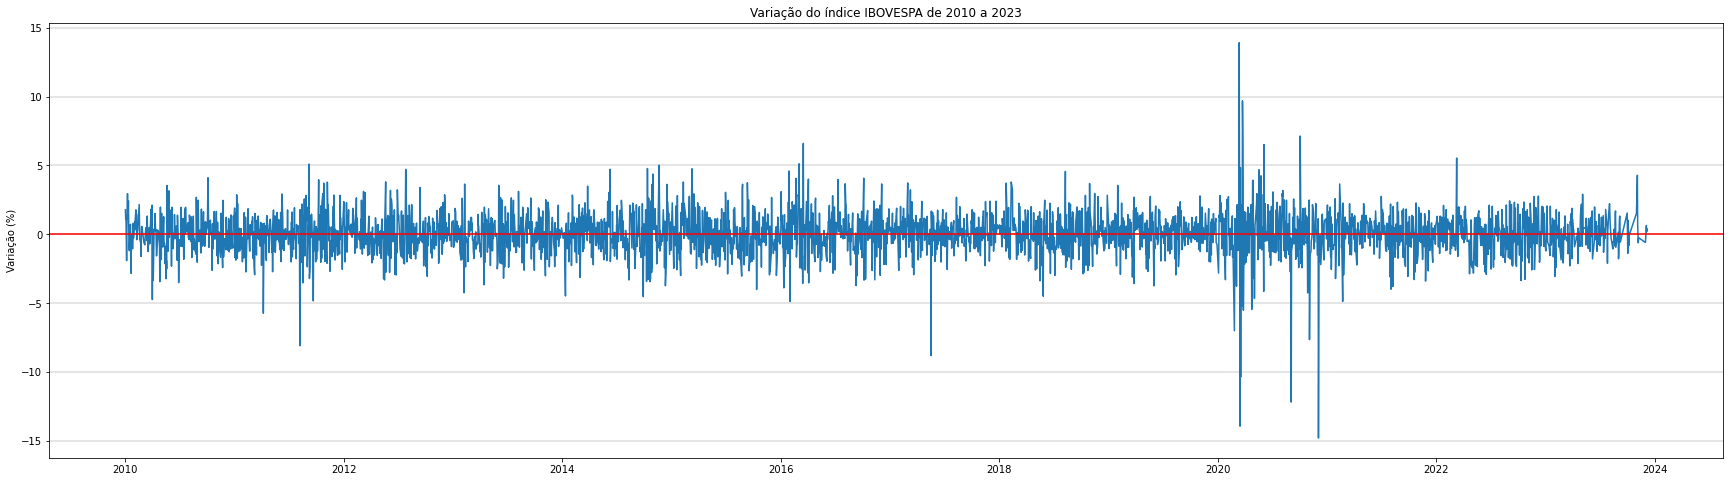

In [59]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='variacao', ax=ax)
ax.axhline(y=0, color='red')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do índice IBOVESPA de 2010 a 2023')
ax.set_xlabel('')
ax.set_ylabel('Variação (%)')

plt.show()

Percebe-se um gráfico com muitos altos e baixos, porém com a maioria dos valores entre -5% e +5% de variação. 

Ocorrem alguns pontos no gráfico em que a variação ultrapassa esses valores, com destaque novamente para o ano de 2020 que apresentou o comportamento mais incostante na série.

## Volume

Total de valores negociados no dia, em milhões R$

In [61]:
print(f'Volume máximo (milhões R$): {dados.volume.max()}')
print(dados.loc[dados.volume == dados.volume.max()]['ds'])

print('\n')

print(f'Volume mínimo (milhões R$): {dados.volume.min()}')
print(dados.loc[dados.volume == dados.volume.min()]['ds'])

Volume máximo (milhões R$): 981.63
3158   2010-11-25
Name: ds, dtype: datetime64[ns]


Volume mínimo (milhões R$): 1.0
3009   2011-04-07
Name: ds, dtype: datetime64[ns]


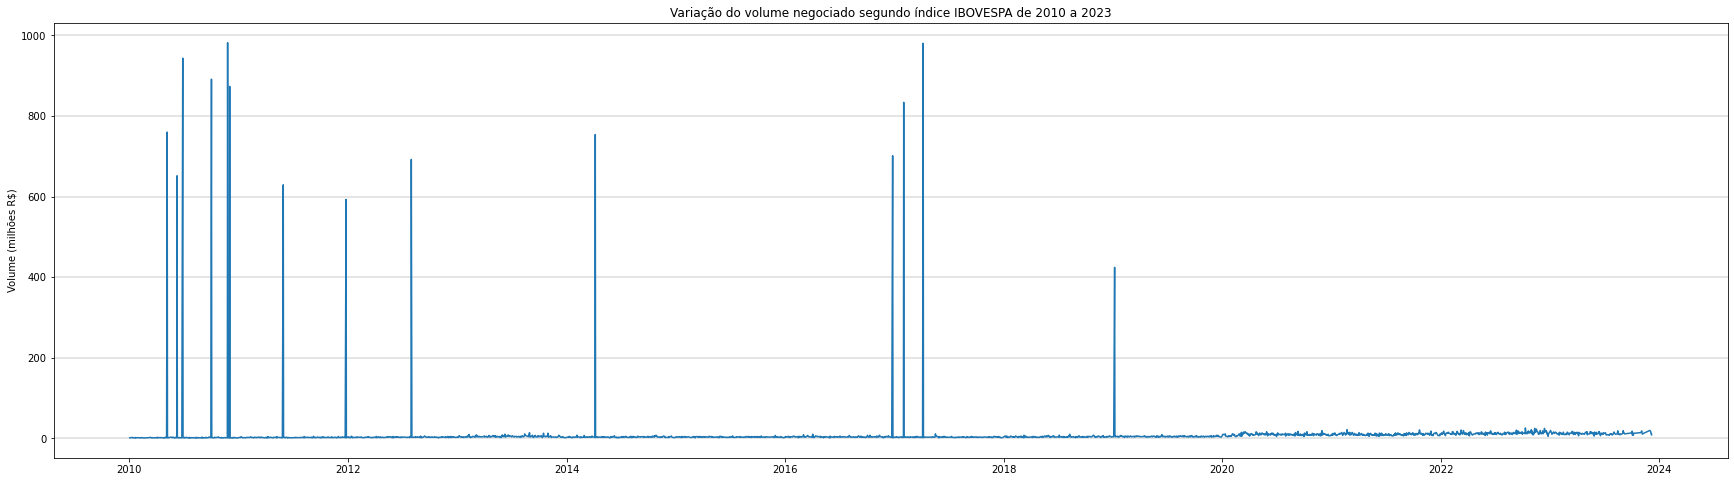

In [65]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='volume', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do volume negociado segundo índice IBOVESPA de 2010 a 2023')
ax.set_xlabel('')
ax.set_ylabel('Volume (milhões R$)')

plt.show()

O gráfico indica outliers muito acima do normal para os valores de volume negociados em bolsa, é um indício que a base de dados pode ter inconsistências nesse sentido.

Checando na base original, foi verificado que existiam valores na unidade de milhares de R$ em meio à grande maioria das linhas representadas em milhões de R$. Ou seja, os outliers que surgiram na verdade devem ser divididos por 1000 para ajustá-los para a unidade milhões de R$

In [66]:
# Linhas da base com volume em milhares de R$
dados.loc[dados.volume > 100]

,ds,y,abertura,max,min,volume,variacao
1034,2019-01-07,101.340,100.973,102.432,100.973,424.32,0.37
1523,2017-04-07,63.232,63.268,63.346,63.076,980.07,-0.08
1647,2017-02-01,59.589,60.227,60.227,59.371,833.73,-1.06
1651,2016-12-26,58.620,57.941,58.781,57.941,701.23,1.18
2266,2014-04-07,54.056,53.893,54.087,53.704,753.84,0.34
2740,2012-07-31,56.097,57.243,57.466,56.097,692.08,-2.00
2888,2011-12-26,57.669,57.702,57.856,57.669,592.75,-0.05
3033,2011-05-30,63.954,64.295,64.460,63.915,629.04,-0.53
3158,2010-11-25,69.362,69.634,69.780,69.362,981.63,-0.38
3212,2010-06-09,66.747,66.679,66.949,66.380,651.48,0.10


In [67]:
# Conversão para milhões de R$
dados.loc[dados.volume > 100, 'volume'] = dados.volume/1000

In [68]:
dados.loc[dados.volume > 100]

,ds,y,abertura,max,min,volume,variacao


In [70]:
print(f'Volume máximo (milhões R$): {dados.volume.max()}')
print(dados.loc[dados.volume == dados.volume.max()]['ds'])

print('\n')

print(f'Volume mínimo (milhões R$): {dados.volume.min()}')
print(dados.loc[dados.volume == dados.volume.min()]['ds'])

Volume máximo (milhões R$): 26.03
197   2022-10-11
Name: ds, dtype: datetime64[ns]


Volume mínimo (milhões R$): 0.42432
1034   2019-01-07
Name: ds, dtype: datetime64[ns]


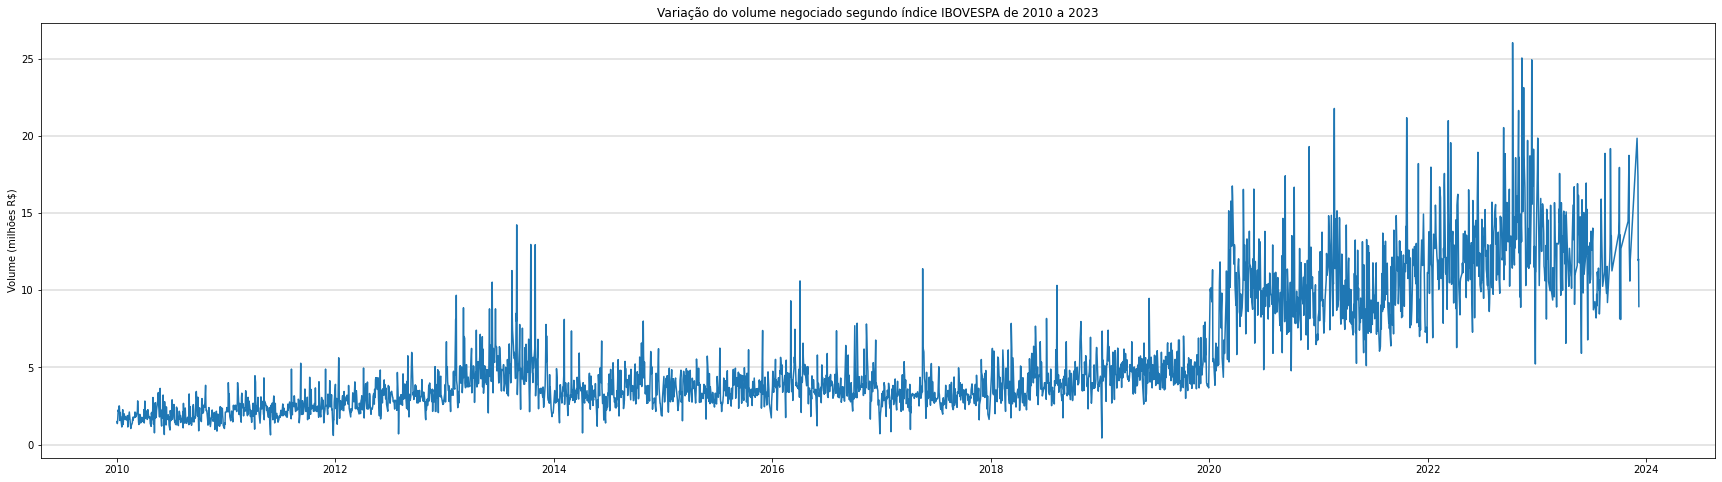

In [69]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='volume', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do volume negociado segundo índice IBOVESPA de 2010 a 2023')
ax.set_xlabel('')
ax.set_ylabel('Volume (milhões R$)')

plt.show()

Agora, o gráfico ilustra bem a evolução do mercado variável no Brasil. É visível que, até meados de 2019, o volume de negociações sofreu pouca alteração com uma leve tendência de crescimento.

Com a redução nas taxas de juros e Selic, e consequentemente a baixa nos investimentos de Renda Fixa, o mercado de Renda Variável teve um boom muito grande a partir de 2020.

https://www.cnnbrasil.com.br/economia/numero-de-investidores-na-bolsa-cresce-15-em-2022-apostando-na-diversificacao/